In [243]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,cross_val_score
import warnings
warnings.filterwarnings('ignore')
import ast
from src.perm_imp import *
from sklearn.metrics import confusion_matrix
import matplotlib.pylab as plt
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score,recall_score,precision_score,roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [18]:
#fill nulls and take a subset of features
def clean(df):
    #very few nulls in the data set -- filling them with the column mean
    df.fillna(df.mean(),inplace=True)
    #subset of data features based on EDA and correlation analysis
    data1=df[['TEETHLOST_CrudePrev','STROKE_CrudePrev','PHLTH_CrudePrev','OBESITY_CrudePrev','MHLTH_CrudePrev','LPA_CrudePrev','KIDNEY_CrudePrev','DENTAL_CrudePrev','DIABETES_CrudePrev','CSMOKING_CrudePrev','COREW_CrudePrev','COPD_CrudePrev','CHOLSCREEN_CrudePrev','CASTHMA_CrudePrev','ACCESS2_CrudePrev','PovertyRate','TractSNAP','comp_healthy','comp_unhealthy','comp_grocery','comp_ff','Population2010','PCTGQTRS','HUNVFlag']]
    data1['TractLOWI']=df['TractLOWI']/df['Population2010']
    data1['TractKids']=df['TractKids']/df['Population2010']
    data1['TractSeniors']=df['TractSeniors']/df['Population2010']
    data1['TractWhite']=df['TractWhite']/df['Population2010']
    data1['TractBlack']=df['TractBlack']/df['Population2010']
    data1['TractAsian']=df['TractAsian']/df['Population2010']
    data1['TractNHOPI']=df['TractNHOPI']/df['Population2010']
    data1['TractAIAN']=df['TractAIAN']/df['Population2010']
    data1['TractOMultir']=df['TractOMultir']/df['Population2010']
    data1['TractHispanic']=df['TractHispanic']/df['Population2010']
    data1['TractHUNV']=df['TractHUNV']/df['Population2010']
    data1['TractSNAP']=df['TractSNAP']/df['Population2010']
    return data1

In [127]:
#prepping data for modeling
def prep_data():

    #food desert data + poverty rates + SNAP counts
    food_desert = pd.ExcelFile('data/food_desert_data.xlsx')

    #just want  data, other sheets in the excel workbook are a readME and variable description
    desert_data = food_desert.parse(2)
    #set index to prepare for merging data sets
    desert_data['CensusTract']=desert_data['CensusTract'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    desert_data.set_index('CensusTract', inplace=True)


    #behavior and health data 
    behav = pd.read_csv('data/population_health.csv',)
    #setting index to the same feature as desert_data
    behav['TractFIPS']=behav['TractFIPS'].apply(lambda x: "0"+str(x) if len(str(x))==10 else str(x)) 
    behav.set_index('TractFIPS', inplace=True)

    #merge the data sets tp create our large dataset
    merge1 = behav.merge(desert_data, how='inner', left_index=True, right_index=True)    

    #ready for splitting data
    #target food desert classification
    y=merge1.pop('LILATracts_halfAnd10')
    #feature matrix
    X=merge1
    X['county'] = [i[:5] for i in X.index]
    
    print("Preparing Healthy DF")
    healthy_clean=pd.read_csv('data/twitter_mongo/healthy_final.csv',index_col=0)
    healthy_clean['comp_healthy']=healthy_clean['comp']
    county_sent_healthy = healthy_clean.groupby('county').mean()['comp_healthy']
    county_sent_healthy = county_sent_healthy.reset_index()
    
    print("Preparing Unealthy DF")
    unhealthy_clean=pd.read_csv('data/twitter_mongo/unhealthy_final.csv',index_col=0)
    unhealthy_clean['comp_unhealthy']=unhealthy_clean['comp']
    county_sent_unhealthy = unhealthy_clean.groupby('county').mean()['comp_unhealthy']
    county_sent_unhealthy = county_sent_unhealthy.reset_index()
    
    print("Preparing Grocery DF")
    grocery_stores_clean=pd.read_csv('data/twitter_mongo/grocery_stores_final.csv',index_col=0)
    grocery_stores_clean['comp_grocery']=grocery_stores_clean['comp']
    county_sent_grocery = grocery_stores_clean.groupby('county').mean()['comp_grocery']
    county_sent_grocery = county_sent_grocery.reset_index()
 
    print("Preparing FF DF")
    ff_stores_clean=pd.read_csv('data/twitter_mongo/ff_stores_final.csv',index_col=0)
    ff_stores_clean['comp_ff']=ff_stores_clean['comp']
    county_sent_ff = ff_stores_clean.groupby('county').mean()['comp_ff']
    county_sent_ff = county_sent_ff.reset_index()
    
    print("Merging county sentiment")
    X1 = pd.merge(X,county_sent_healthy,how='left',left_on='county', right_on='county')
    X2 = pd.merge(X1,county_sent_unhealthy,how='left',left_on='county', right_on='county')
    X3 = pd.merge(X2,county_sent_grocery,how='left',left_on='county', right_on='county')
    X4 = pd.merge(X3,county_sent_ff,how='left',left_on='county', right_on='county')

    X4.fillna(-1,inplace=True)

    #train test split
    X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.20, random_state=42)

    #perform cleaning on each dataset independently to prep for model fit and predict
    print("Cleaning train and test DF")
    df_train = clean(X_train)
    df_test = clean(X_test)

    #return training and testing sets
    return df_train,y_train,df_test,y_test

In [20]:
df_train,y_train,df_test,y_test = prep_data()

Preparing Healthy DF
Preparing Unealthy DF
Preparing Grocery DF
Preparing FF DF
Merging county sentiment
Cleaning train and test DF


In [234]:
#SVM
model = LinearSVC(penalty='l2',loss='hinge')
print("SVM")
print()

print("TRAIN on SVM")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_svm = model.decision_function(df_test)
fpr_svm,tpr_svm,thresholds=roc_curve(y_test.values,y_predproba_svm)

print()
print("TEST on SVM")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

SVM

TRAIN on SVM
ROC_AUC score:  0.7560622068751665
Accuracy score:  0.6378767474426021
f1 score:  0.38411239530284014

TEST on SVM
ROC_AUC score:  0.7330257082968499
Accuracy score:  0.7167800036757949
f1 score:  0.6672424962211184
recall score:  0.7906857727737974
precision score:  0.57713858797161


In [224]:
#KNN
print("KNN")
print()
model = KNeighborsClassifier(n_neighbors=5)
#train stats
print("TRAIN on KNN")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

#predict and get test stats
model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_knn = model.predict_proba(df_test)
fpr_knn,tpr_knn,thresholds=roc_curve(y_test.values,y_predproba_knn[:,1])

print()
print("TEST on RF")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

KNN

TRAIN on KNN
ROC_AUC score:  0.8202045901048042
Accuracy score:  0.7587644613755219
f1 score:  0.6642602224586309

TEST on RF
ROC_AUC score:  0.7428335954073017
Accuracy score:  0.7610733321080684
f1 score:  0.6708860759493671
recall score:  0.6780962128966224
precision score:  0.6638276553106213


In [195]:
#Logistic Reg
model = LogisticRegression(penalty='l1')
print("LogReg")
print()

print("TRAIN on LogReg")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_lr = model.predict_proba(df_test)
fpr_lr,tpr_lr,thresholds=roc_curve(y_test.values,y_predproba_lr[:,1])


print()
print("TEST on LogReg")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

LogReg

TRAIN on LogReg
ROC_AUC score:  0.9060321819200775
Accuracy score:  0.8210266161943757
f1 score:  0.7389965714794786

TEST on LogReg
ROC_AUC score:  0.7929091942318874
Accuracy score:  0.8180481529130674
f1 score:  0.7352941176470589
recall score:  0.7036847492323439
precision score:  0.7698768197088466


In [244]:
#Decision Tree
print("Decision Tree")
print()
model = DecisionTreeClassifier()
#train stats
print("TRAIN on DT")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

#predict and get test stats
model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_dt = model.predict_proba(df_test)
fpr_dt,tpr_dt,thresholds=roc_curve(y_test.values,y_predproba_dt[:,1])

print()
print("TEST on DT")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

Decision Tree

TRAIN on DT
ROC_AUC score:  0.8203235642801717
Accuracy score:  0.8370627487297468
f1 score:  0.7696953746965376

TEST on DT
ROC_AUC score:  0.8179701825672722
Accuracy score:  0.8312810145193898
f1 score:  0.7664122137404581
recall score:  0.7707267144319345
precision score:  0.7621457489878543


In [29]:
#GB 1
model = GradientBoostingClassifier()
print("GRADIENT BOOSTING")
print()

print("TRAIN on GB")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)

print()
print("TEST on GB")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

GRADIENT BOOSTING

TRAIN on GB
ROC_AUC score:  0.9520615656566216
Accuracy score:  0.8826449030249591
f1 score:  0.8355648452275559

TEST on GB
ROC_AUC score:  0.8719277245296833
Accuracy score:  0.8845800404337438
f1 score:  0.8373056994818652
recall score:  0.827021494370522
precision score:  0.8478488982161595


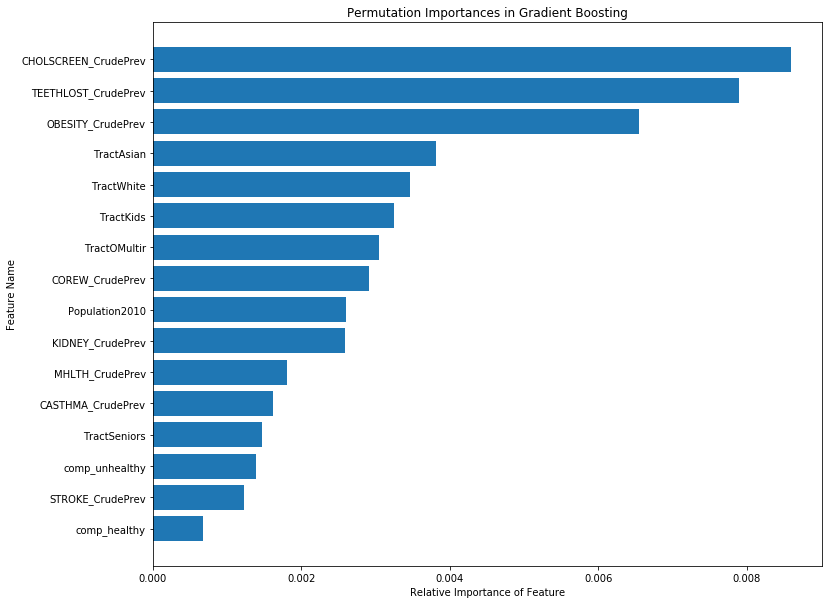

In [190]:
#GB
f_imp = permutation_importance(model,df_test.values,y_test.values)
fig,ax = plt.subplots(1,1,figsize=(12,10))
plot_feat_import(f_imp, df_test.columns, 20)

In [118]:
#gradient boosting grid search
gb_grid = {'n_estimators': [10,50,100],
                  'min_samples_leaf': [1, 7, 9, 13],
                  'max_depth': [2, 3, 4, 5],
                  'max_features': [2, 5, 10, 12,15,20],
                  'learning_rate': [0.01,.1,1]}
gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                             gb_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
gb_gridsearch.fit(df_train, y_train)

print( "best parameters:", gb_gridsearch.best_params_ )

best_gb_model = gb_gridsearch.best_estimator_

Fitting 3 folds for each of 864 candidates, totalling 2592 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    9.9s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:  7.6min
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 1792 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 2442 tasks      | elapsed: 25.4min
[Parallel(n_jobs=-1)]: Done 2592 out of 2592 | elapsed: 28.1min finished


best parameters: {'learning_rate': 0.1, 'max_depth': 5, 'max_features': 20, 'min_samples_leaf': 13, 'n_estimators': 100}


In [192]:
model = best_gb_model

In [193]:
model

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=5,
              max_features=20, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=13, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [152]:
import pickle
with open('model.pkl', 'wb') as f:
        # Write the model to a file.
        pickle.dump(model, f)

In [121]:
#GB
print("GRADIENT BOOSTING")
print()

print("TRAIN on GB")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_gb = model.predict_proba(df_test)
fpr_gb,tpr_gb,thresholds=roc_curve(y_test.values,y_predproba_gb[:,1])

print()
print("TEST on GB")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

GRADIENT BOOSTING

TRAIN on GB
ROC_AUC score:  0.9565249971964267
Accuracy score:  0.888894047884488
f1 score:  0.8430242172854554

TEST on GB
ROC_AUC score:  0.8756138827092529
Accuracy score:  0.8884396250689212
f1 score:  0.84237860296027
recall score:  0.8300921187308086
precision score:  0.8550342646283605


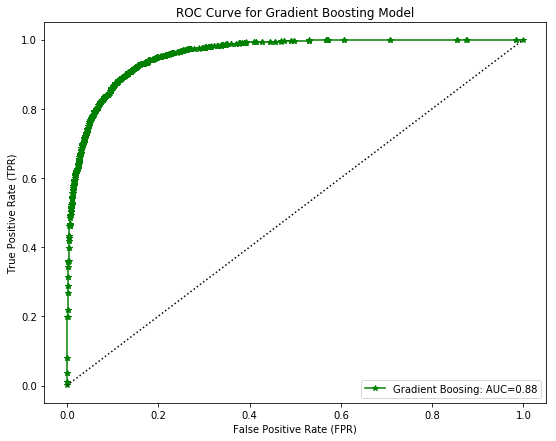

In [226]:
#ROC:
fig,ax = plt.subplots(1,1,figsize=(9,7))
ax.plot(fpr_gb, tpr_gb,label='Gradient Boosing: AUC=0.88',marker='*', color='green')
ax.plot([0,1],[0,1], 'k:')
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("ROC Curve for Gradient Boosting Model")
#ax.plot(fpr_rf, tpr_rf,label='Random Forest',marker='*', color='blue',alpha=.5)
ax.legend(loc='lower right')

In [124]:
#grid search for RF
param_grid={'n_estimators': [200,300,400],
            'max_depth': [3, None,1,2,5,7,10],
            'max_features': ['sqrt','log2', None]
           }

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                             param_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='roc_auc')
rf_gridsearch.fit(df_train,y_train)

best_estimator = rf_gridsearch.best_params_

Fitting 3 folds for each of 63 candidates, totalling 189 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.4min
[Parallel(n_jobs=-1)]: Done 189 out of 189 | elapsed: 28.7min finished


In [231]:
best_estimator

{'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 400}

In [232]:
model = RandomForestClassifier(max_depth= None,max_features='sqrt',n_estimators=400)

In [233]:
model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_rf = model.predict_proba(df_test)
fpr_rf,tpr_rf,thresholds=roc_curve(y_test.values,y_predproba_rf[:,1])

In [126]:
#RF model
#new RF params
print("RANDOM FOREST GS")
print()

#train stats
print("TRAIN on RF")
print("ROC_AUC score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='roc_auc').mean())
print("Accuracy score: ", cross_val_score(model,df_train,y_train,cv=5).mean())
print("f1 score: ", cross_val_score(model,df_train,y_train,cv=5,scoring='f1').mean())

#predict and get test stats
model.fit(df_train,y_train)
y_pred = model.predict(df_test)
y_predproba_rf = model.predict_proba(df_test)
fpr_rf,tpr_rf,thresholds=roc_curve(y_test.values,y_predproba_rf[:,1])

print()
print("TEST on RF")
print("ROC_AUC score: ", roc_auc_score(y_test,y_pred))
print("Accuracy score: ", accuracy_score(y_test,y_pred))
print("f1 score: ", f1_score(y_test,y_pred))
print("recall score: ", recall_score(y_test,y_pred))
print("precision score: ", precision_score(y_test,y_pred))

RANDOM FOREST GS

TRAIN on RF
ROC_AUC score:  0.956528802447713
Accuracy score:  0.8880209072343618
f1 score:  0.8429511076519292

TEST on RF
ROC_AUC score:  0.8727262747229878
Accuracy score:  0.8853151994118729
f1 score:  0.8383419689119171
recall score:  0.8280450358239508
precision score:  0.8488982161594963


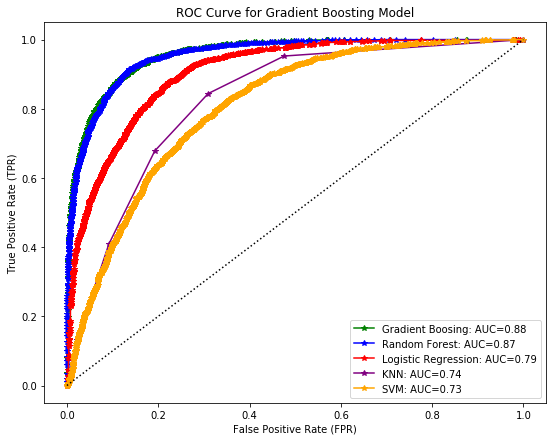

In [246]:
#ROC:
fig,ax = plt.subplots(1,1,figsize=(9,7))
ax.plot(fpr_gb,tpr_gb,label='Gradient Boosing: AUC=0.88',marker='*', color='green')
ax.plot(fpr_rf, tpr_rf,label='Random Forest: AUC=0.87',marker='*', color='blue')
ax.plot(fpr_lr, tpr_lr,label='Logistic Regression: AUC=0.79',marker='*', color='red')
ax.plot(fpr_knn, tpr_knn,label='KNN: AUC=0.74',marker='*', color='purple')
ax.plot(fpr_svm, tpr_svm,label='SVM: AUC=0.73',marker='*', color='orange')
#ax.plot(fpr_dt, tpr_dt,label='Decision Tree: AUC=0.82',marker='*', color='pink')
ax.plot([0,1],[0,1], 'k:')
ax.set_xlabel("False Positive Rate (FPR)")
ax.set_ylabel("True Positive Rate (TPR)")
ax.set_title("ROC Curve for Gradient Boosting Model")
ax.legend(loc='lower right')

fig.savefig("images/ROC_compare.png")